In this notebook we analyse the regret for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

To measure regret, we use a policy learned with full reward information each time step.

The measure of comparison is the average return over all runs at the final episode $K_{max}$, $G_{avg,K_{max}} = \frac{1}{K_{max}}\sum^{K_{max}}_{K=1} G_{k}$.

Then we average that across runs, and compute the returns ratio as: $\frac{\mu_{\bar{G}^{m}_{K}} - \mu_{\bar{G}^{FR}_{K}}}{\vert \mu_{\bar{G}^{FR}_{K}} \rvert}$.
It tells us the percentage difference in average return between the policy trained with algorithm $m$ compared to the full rewards policy.
Lower is better.

Key on methods:

  - "PP/FR": Full rewards information
  - "PP/IMR": Impute missing rewards (zero when absent)
  - "PP/LEAST-LFA": Reward estimation
  - "OP-A/FR": Options policy, with composition actions as options
  - "OP-S/FR": Options policy, with repeated single action as options

In [1]:
import copy
import os
import pathlib
from typing import Set
import itertools

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats

In [3]:
import matplotlib
from matplotlib import pyplot as plt

In [4]:
from drmdp import dataproc

In [5]:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [6]:
import warnings  # To suppress some warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [7]:
files = tf.io.gfile.glob(
    f"{pathlib.Path.home()}/fs/drmdp/workflows/controljob/agg/1763050698/1763058268/metrics/*.parquet"
)

In [8]:
df_metrics = dataproc.read_data(files, reader="pd")

In [9]:
df_metrics

,episode,exp_id,meta,returns,steps,metrics,method
0,60,1763050698-0116b72c-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[1549.9503623735377, 1558.7936667120832, 1502....","[330, 1098, 488, 308, 7, 7, 361, 7, 265, 508, ...","{'returns': {'mean': 785.2603900635597, 'std':...",IMR
1,60,1763050698-01376e3a-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[1362.1999149050525, 4.9933992951779835, 4.958...","[1016, 7, 7, 875, 10, 948, 1237, 350, 282, 11,...","{'returns': {'mean': 697.7584891426144, 'std':...",BLADE-TD
2,60,1763050698-025fc2cc-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[11812.216201251267, 10725.27666627742, 11021....","[10000, 2378, 3091, 2718, 10000, 10000, 5260, ...","{'returns': {'mean': 10882.047036944263, 'std'...",OP-A
3,60,1763050698-03997039-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[2493.1601525614333, 247.95767310065654, 613.1...","[4987, 17, 1611, 10000, 4716, 10000, 10000, 70...","{'returns': {'mean': 6865.64643421407, 'std': ...",BLADE-TD
4,60,1763050698-03c0d284-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[425.42135438737756, 2.8910620204350597, 13.22...","[647, 8, 10, 841, 394, 203, 656, 190, 7, 503, ...","{'returns': {'mean': 1044.0259757121707, 'std'...",BLADE-TD
...,...,...,...,...,...,...,...
246,110,1763050698-f82c3789-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[1201.5786284653914, 1284.4579611910822, 1014....","[481, 718, 531, 711, 530, 444, 405, 326, 884, ...","{'returns': {'mean': 981.9631833080044, 'std':...",BLADE-TD
247,110,1763050698-fd5aaaea-Finite-CC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[2361.1303144102485, 16977.873333187345, 13658...","[879, 10000, 10000, 10000, 1753, 760, 429, 100...","{'returns': {'mean': 10127.974338150085, 'std'...",IMR
248,110,1763050698-fd5e4b47-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[478.2993068247551, 1437.6164056802636, 1381.5...","[1085, 780, 415, 399, 187, 898, 511, 678, 439,...","{'returns': {'mean': 1079.209994423617, 'std':...",BLADE-TD[N-B]
249,110,1763050698-fe3af879-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[736.6548933136625, 255.85963865401706, 1278.5...","[941, 697, 658, 425, 896, 233, 276, 750, 629, ...","{'returns': {'mean': 942.4013851906973, 'std':...",BLADE-TD


In [10]:
df_metrics.iloc[0]["meta"]

{'context': {'dummy': 0},
 'exp_id': '1763050698-0116b72c-Finite-SC-ShuntDc-v0',
 'instance_id': 11,
 'run_config': {'episodes_per_run': 500,
  'log_episode_frequency': 10,
  'num_runs': 20,
  'output_dir': 'gs://mo-hendrix-ml-workflows-storage/drmdp/workflows/controljob/logs/1763050698/1763050698-0116b72c-Finite-SC-ShuntDc-v0/run_11/impute-missing/d99f392a',
  'use_seed': True},
 'env_spec': {'args': {'constraint_violation_reward': -10.0,
   'emit_state': True,
   'max_episode_steps': 10000,
   'penalty_gamma': 1.0,
   'reward_fn': 'pos-enf'},
  'feats_spec': {'args': None, 'name': 'scale'},
  'name': 'Finite-SC-ShuntDc-v0'},
 'epochs': 1,
 'problem_spec': {'delay_config': {'args': {'lam': 4.0,
    'max_delay': None,
    'min_delay': 2.0},
   'name': 'clipped-poisson'},
  'epsilon': 0.1,
  'gamma': 1.0,
  'learning_rate_config': {'args': {'initial_lr': 0.01}, 'name': 'constant'},
  'policy_type': 'markovian',
  'reward_mapper': {'args': {'attempt_estimation_episode': None,
    'check_

In [11]:
df_metrics

,episode,exp_id,meta,returns,steps,metrics,method
0,60,1763050698-0116b72c-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[1549.9503623735377, 1558.7936667120832, 1502....","[330, 1098, 488, 308, 7, 7, 361, 7, 265, 508, ...","{'returns': {'mean': 785.2603900635597, 'std':...",IMR
1,60,1763050698-01376e3a-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[1362.1999149050525, 4.9933992951779835, 4.958...","[1016, 7, 7, 875, 10, 948, 1237, 350, 282, 11,...","{'returns': {'mean': 697.7584891426144, 'std':...",BLADE-TD
2,60,1763050698-025fc2cc-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[11812.216201251267, 10725.27666627742, 11021....","[10000, 2378, 3091, 2718, 10000, 10000, 5260, ...","{'returns': {'mean': 10882.047036944263, 'std'...",OP-A
3,60,1763050698-03997039-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[2493.1601525614333, 247.95767310065654, 613.1...","[4987, 17, 1611, 10000, 4716, 10000, 10000, 70...","{'returns': {'mean': 6865.64643421407, 'std': ...",BLADE-TD
4,60,1763050698-03c0d284-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[425.42135438737756, 2.8910620204350597, 13.22...","[647, 8, 10, 841, 394, 203, 656, 190, 7, 503, ...","{'returns': {'mean': 1044.0259757121707, 'std'...",BLADE-TD
...,...,...,...,...,...,...,...
246,110,1763050698-f82c3789-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[1201.5786284653914, 1284.4579611910822, 1014....","[481, 718, 531, 711, 530, 444, 405, 326, 884, ...","{'returns': {'mean': 981.9631833080044, 'std':...",BLADE-TD
247,110,1763050698-fd5aaaea-Finite-CC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[2361.1303144102485, 16977.873333187345, 13658...","[879, 10000, 10000, 10000, 1753, 760, 429, 100...","{'returns': {'mean': 10127.974338150085, 'std'...",IMR
248,110,1763050698-fd5e4b47-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[478.2993068247551, 1437.6164056802636, 1381.5...","[1085, 780, 415, 399, 187, 898, 511, 678, 439,...","{'returns': {'mean': 1079.209994423617, 'std':...",BLADE-TD[N-B]
249,110,1763050698-fe3af879-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[736.6548933136625, 255.85963865401706, 1278.5...","[941, 697, 658, 425, 896, 233, 276, 750, 629, ...","{'returns': {'mean': 942.4013851906973, 'std':...",BLADE-TD


In [12]:
envs = dataproc.get_distinct_envs(df_metrics)

In [13]:
envs

{'Finite-SC-ShuntDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': True,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-TC-ShuntDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': True,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-ShuntDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-TC-PermExDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-SC-PermExDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-PermExDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'po

In [14]:
METHODS = sorted(df_metrics["method"].unique())

In [15]:
METHODS

['BLADE-TD', 'BLADE-TD[N-B]', 'DMR', 'FR', 'IMR', 'OP-A']

In [16]:
def parse_delay_config(df_input: pd.DataFrame):
    df = copy.deepcopy(df_input)

    def parse_mu(delay_config):
        if delay_config is None:
            return None
        args = delay_config["args"]
        try:
            return args["delay"]
        except KeyError:
            return args["lam"]
        except KeyError as exc:
            raise ValueError(f"Unknown delay config {args}") from exc

    df["delay_type"] = df["delay_config"].apply(lambda dc: dc["name"] if dc else None)
    df["delay_mu"] = df["delay_config"].apply(parse_mu)
    del df["delay_config"]
    return df

In [17]:
def max_episode_filter(df_input):
    env_spec = df_input["meta"].apply(lambda meta: meta["env_spec"])
    env_name = env_spec.apply(lambda spec: spec["name"])
    envs = env_name.unique()
    dfs = []
    for env in envs:
        df_slice = df_input[(env_name == env)]
        df_slice = df_slice[df_slice["episode"] == df_slice["episode"].max()]
        dfs.append(copy.deepcopy(df_slice))
    return pd.concat(dfs)

In [18]:
def extract_salient_meta_fields(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data)

    specs = {
        "env": df_raw["meta"].apply(lambda meta: meta["env_spec"]),
        "feats": df_raw["meta"].apply(lambda meta: meta["env_spec"]["feats_spec"]),
    }

    for prefix, col_fam in specs.items():
        for col in ("name", "args"):
            df_raw[f"{prefix}_{col}"] = col_fam.apply(lambda spec: spec[col])

    for key in (
        "delay_config",
        "gamma",
    ):
        df_raw[key] = df_raw["meta"].apply(lambda meta: meta["problem_spec"][key])
    return parse_delay_config(df_raw)

## Regret - Relative to full rewards observation

In [19]:
def calculate_regret_over_configurations(df_data):
    def calc_regret(y_pred, y_oracle):
        # agg returns
        mean_y_oracle = np.mean(y_oracle)
        return (np.mean(y_pred) - mean_y_oracle) / np.abs(mean_y_oracle)

    df_result = max_episode_filter(df_data)
    df_result = extract_salient_meta_fields(df_result)

    df_baseline = df_result[pd.isnull(df_result["delay_type"])]
    df_result = df_result[~pd.isnull(df_result["delay_type"])]

    baselines = {}
    keys = ["env_name", "gamma", "delay_config"]
    for row in df_baseline.to_dict("records"):
        key = tuple(row[key] for key in keys[:-1])
        baselines[key] = row["returns"]

    for key in sorted(baselines.keys()):
        print(key)

    rows = []
    for row in df_result.to_dict("records"):
        key = tuple([row[key] for key in keys[:-1]])
        full_reward_mean_return = baselines[key]
        regret = calc_regret(y_pred=row["returns"], y_oracle=full_reward_mean_return)
        row["relative_regret"] = regret
        row["method"] = row["method"]
        rows.append(row)

    df_regret = pd.DataFrame(rows)
    df_regret = df_regret[
        ["env_name", "method", "delay_type", "delay_mu", "relative_regret"]
    ].sort_values(["env_name", "method", "delay_type", "delay_mu"])
    return {"sarsa": df_regret}

In [20]:
METHODS_PALETTES = {
    key: palette for key, palette in zip(dataproc.ORDERED_METHODS, sns.color_palette())
}

In [21]:
METHODS_PALETTES

{'BLADE-TD': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'BLADE-TD[N-B]': (1.0, 0.4980392156862745, 0.054901960784313725),
 'IMR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'OP-A': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'OP-S': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'DMR': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'FR': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

In [22]:
def plot_regret(
    df_data, suffix=None, method_filter_fn=lambda met: True, output_dir="figures/regret"
):
    df_raw = copy.deepcopy(
        df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]]
    )
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    rps = sorted(df_raw["delay_mu"].unique())

    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(rps),
        figsize=(4 * len(rps), 4),
        sharey=False,
    )

    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["delay_mu"] == rp]
        sns.boxplot(
            df_plot,
            x="env_name",
            y="relative_regret",
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns Ratio")
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(len(rps) / 2.0, 1.3),
                ncol=3,
                fancybox=True,
            )
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches="tight")

In [23]:
dfs_regret = calculate_regret_over_configurations(df_metrics)

('Finite-CC-PermExDc-v0', 0.99)
('Finite-CC-PermExDc-v0', 1.0)
('Finite-CC-ShuntDc-v0', 0.99)
('Finite-CC-ShuntDc-v0', 1.0)
('Finite-SC-PermExDc-v0', 0.99)
('Finite-SC-PermExDc-v0', 1.0)
('Finite-SC-ShuntDc-v0', 0.99)
('Finite-SC-ShuntDc-v0', 1.0)
('Finite-TC-PermExDc-v0', 0.99)
('Finite-TC-PermExDc-v0', 1.0)
('Finite-TC-ShuntDc-v0', 0.99)
('Finite-TC-ShuntDc-v0', 1.0)


In [24]:
dfs_regret["sarsa"]

,env_name,method,delay_type,delay_mu,relative_regret
184,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,2.0,0.081492
200,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,2.0,-0.030529
191,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,4.0,-0.037908
198,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,4.0,-0.010316
197,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,6.0,0.051390
...,...,...,...,...,...
67,Finite-TC-ShuntDc-v0,IMR,clipped-poisson,8.0,-0.343152
57,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,2.0,-0.985223
63,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,2.0,-0.912047
44,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,4.0,-0.898086


In [25]:
dfs_regret["sarsa"]["env_name"].unique()

array(['Finite-CC-PermExDc-v0', 'Finite-CC-ShuntDc-v0',
       'Finite-SC-PermExDc-v0', 'Finite-SC-ShuntDc-v0',
       'Finite-TC-PermExDc-v0', 'Finite-TC-ShuntDc-v0'], dtype=object)

In [26]:
sorted(dfs_regret["sarsa"]["delay_mu"].unique())

[2.0, 4.0, 6.0, 8.0]

In [27]:
dfs_regret["sarsa"].dtypes

env_name            object
method              object
delay_type          object
delay_mu           float64
relative_regret    float64
dtype: object

In [28]:
def filter_envs(df_input, envs: Set[str]):
    mask = df_input["env_name"].apply(lambda name: name in envs)
    return copy.copy(df_input[mask])

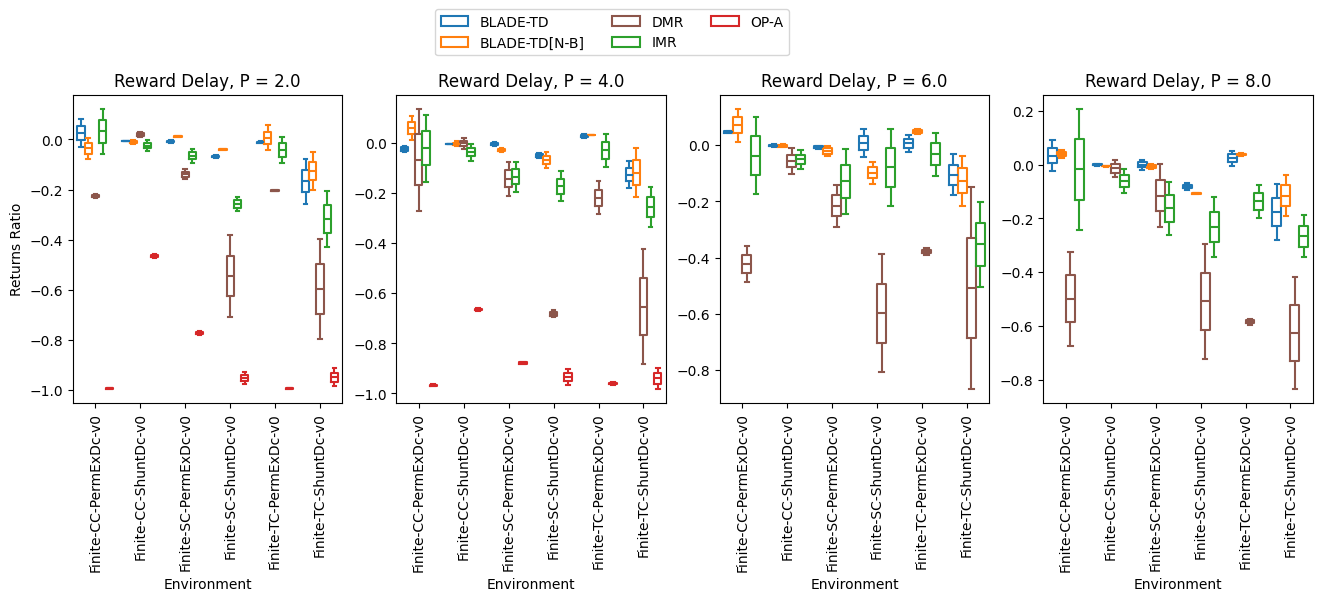

In [29]:
plot_regret(dfs_regret["sarsa"], suffix="sarsa")

## Proc Data: Run Return Matrix

For the next metrics, we need a matrix where each run is is a row, and the columns represent returns at each episode.

In [30]:
def calc_runs_returns_matrix(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(
        df_data[["episode", "exp_id", "returns", "steps", "meta", "method"]]
    )

    rows = []
    experiments = df_metrics["exp_id"].unique()
    for exp_id in experiments:
        df_exp = df_raw[df_raw["exp_id"] == exp_id]
        example = df_exp.iloc[0]
        # get episodes time series
        episodes = np.array(df_exp["episode"].values)
        # matrix of return (rows) x run (columns)
        returns = np.stack(df_exp["returns"].values)
        steps = np.stack(df_exp["steps"].values)
        # sort episodes
        sorting_indices = np.argsort(episodes)
        # reorder returns by episode - earliest to latest
        sorted_returns = returns[sorting_indices, :]
        sorted_steps = steps[sorting_indices, :]
        # transpose matrix to run (rows) x return (columns)
        runs_returns_matrix = np.transpose(sorted_returns)
        runs_steps_matrix = np.transpose(sorted_steps)
        rows.append(
            {
                "exp_id": exp_id,
                "runs_returns_matrix": runs_returns_matrix,
                "runs_steps_matrix": runs_steps_matrix,
                "env_name": example["meta"]["env_spec"]["name"],
                "gamma": example["meta"]["problem_spec"]["gamma"],
                "delay_config": example["meta"]["problem_spec"]["delay_config"],
                "method": example["method"],
                "meta": example["meta"],
                "episodes": np.array(sorted(episodes)),
            }
        )
    return parse_delay_config(pd.DataFrame(rows))

In [31]:
%%time
df_runs_returns = calc_runs_returns_matrix(df_metrics)

CPU times: user 201 ms, sys: 4.07 ms, total: 205 ms
Wall time: 141 ms


In [32]:
df_runs_returns

,exp_id,runs_returns_matrix,runs_steps_matrix,env_name,gamma,method,meta,episodes,delay_type,delay_mu
0,1763050698-0116b72c-Finite-SC-ShuntDc-v0,"[[14272.50959203077, 3.761423074369891, 2373.5...","[[8809, 7, 334, 7, 759, 490, 330, 329, 452, 45...",Finite-SC-ShuntDc-v0,1.00,IMR,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
1,1763050698-01376e3a-Finite-TC-ShuntDc-v0,"[[28.41735305326786, 6.2993577469622775, 5.178...","[[21, 7, 7, 7, 378, 7, 1016, 7, 1478, 7, 836, ...",Finite-TC-ShuntDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0
2,1763050698-025fc2cc-Finite-CC-ShuntDc-v0,"[[18626.034417630966, 15168.512536014448, 1216...","[[10000, 10000, 674, 10000, 10000, 10000, 1000...",Finite-CC-ShuntDc-v0,1.00,OP-A,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0
3,1763050698-03997039-Finite-TC-PermExDc-v0,"[[37.37693281728467, 56.16353942788005, 17.057...","[[28, 23, 118, 361, 1817, 1043, 4987, 8524, 10...",Finite-TC-PermExDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
4,1763050698-03c0d284-Finite-SC-ShuntDc-v0,"[[14.119045999699605, 2457.3722724895765, 3.59...","[[13, 467, 7, 443, 7, 7, 647, 446, 747, 40, 43...",Finite-SC-ShuntDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0
...,...,...,...,...,...,...,...,...,...,...
223,1763050698-f82c3789-Finite-SC-ShuntDc-v0,"[[15681.7349139681, 2.410472948248392, 2198.06...","[[9577, 7, 578, 1176, 387, 766, 307, 753, 133,...",Finite-SC-ShuntDc-v0,1.00,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0
224,1763050698-fd5aaaea-Finite-CC-PermExDc-v0,"[[49.82044417159598, 546.0023313143507, 51.597...","[[36, 117, 120, 39, 253, 10000, 10000, 677, 10...",Finite-CC-PermExDc-v0,1.00,IMR,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0
225,1763050698-fd5e4b47-Finite-TC-ShuntDc-v0,"[[19072.97874081406, 3521.886457838902, 5.2169...","[[10000, 1288, 7, 8, 7, 7, 8, 7, 1084, 8, 408,...",Finite-TC-ShuntDc-v0,1.00,BLADE-TD[N-B],"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
226,1763050698-fe3af879-Finite-SC-ShuntDc-v0,"[[11.738861401646455, 3441.9794209738798, 1.94...","[[15, 1463, 9, 7, 9, 603, 395, 1924, 553, 876,...",Finite-SC-ShuntDc-v0,1.00,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0


In [33]:
np.stack(df_runs_returns.iloc[0]["runs_returns_matrix"])[:2, :]

array([[1.42725096e+04, 3.76142307e+00, 2.37356448e+03, 3.22304363e+00,
        1.87226570e+03, 1.61893546e+03, 1.54995036e+03, 1.40741980e+03,
        1.39892387e+03, 1.28441864e+03, 1.28991621e+03, 1.21818876e+03,
        1.23083446e+03, 2.73496911e+00, 1.24508706e+03, 1.31401462e+03,
        1.30008714e+03, 1.12816734e+03, 2.66232505e+00, 1.29694747e+03,
        1.29766988e+03, 1.30857589e+03, 1.16254996e+03, 1.29888630e+03,
        1.50572015e+02, 1.33975120e+03, 1.30367147e+03, 1.16461132e+03,
        1.31056664e+03, 1.15952411e+03, 3.28259547e+02, 1.18682629e+03,
        3.57971558e+02, 1.34826271e+03, 1.19759842e+03, 1.33235151e+03,
        1.18866729e+03, 1.19117438e+03, 1.35371842e+03, 1.35234613e+03,
        4.56461646e+02, 4.70352671e+02, 1.24096041e+03, 1.37179750e+03,
        1.35436058e+03, 5.15856875e+02, 1.35741383e+03, 1.26766928e+03,
        1.26772936e+03, 1.38789555e+03],
       [4.59406783e+00, 3.31113784e+03, 3.29318413e+00, 2.09210516e+03,
        1.88242045e+03,

In [34]:
np.stack(df_runs_returns.iloc[0]["runs_steps_matrix"])[:2, :]

array([[8809,    7,  334,    7,  759,  490,  330,  329,  452,  455, 1027,
        1315,  674,    8, 1076, 1562,  613,  156,    8,  924,  365, 1630,
         391,  939,  504, 1489, 1020,  557,  504,  436,  440,  922, 1206,
         832,   98, 1455, 1487, 1196,  271,  659,  252,  983,  258,  514,
         972,  517, 1208, 1393,  508,  493],
       [  11, 1165,    7,  892,  730,  675, 1098,  937,  622,  545,  870,
         446,  758,  247,  671,  942,  257,  615, 1807,    7,  500,  721,
        1548, 2670,  955,  854,  715,  783,  709,  853,  198,  866,  881,
         831,  314, 1007,  538,  903,  355,  282, 1208,  182, 4894,  600,
         120, 1012, 1360,  414,  730,  657]])

In [35]:
def calc_ci(xs, confidence: float, method: str = "auto"):
    if method not in ("auto", "t-distribution", "normal"):
        raise ValueError("Method must be one of: {auto, t-distribution, normal}")

    # calculate mean
    mean = np.mean(xs)
    # standard error
    std_err = stats.sem(xs)

    if (method == "auto" and len(xs) < 30) or method == "t-distribution":
        form = "t-distribution"
        lb, ub = stats.t.interval(
            confidence=confidence, df=len(xs) - 1, loc=mean, scale=std_err
        )
    else:
        form = "normal"
        lb, ub = stats.norm.interval(confidence=confidence, loc=mean, scale=std_err)

    ci = np.abs(ub - mean)
    return {"ub": ub, "lb": lb, "mean": mean, "ci": ci, "ci_method": form}

In [36]:
def calc_and_format_ci(xs, confidence: float, decimals: int):
    xs = xs[~np.isnan(xs)]
    if len(xs) == 0:
        xs = [np.nan]
    ci_result = calc_ci(xs, confidence=confidence, method="auto")
    ci_fmt = " ± ".join(
        [
            str(np.around(ci_result["mean"], decimals)),
            str(np.around(ci_result["ci"], decimals)),
        ]
    )
    return ci_result, ci_fmt

In [37]:
def calc_env_method_returns_ci(
    df_results: pd.DataFrame, confidence: float, decimals: int = 4
) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["method"].unique())

    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) & (df_results["method"] == method)
            ]
        )

        # across delays, gamma, and runs
        # shape: config x run x episodes
        returns_matrix = np.stack(df_slice["runs_returns_matrix"].values)
        # take last episode
        returns_matrix = returns_matrix[:, :, -1]
        returns = returns_matrix.flatten()
        ci_result, ci_fmt = calc_and_format_ci(
            returns, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "method"])

In [38]:
calc_env_method_returns_ci(df_runs_returns, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)[["FR", "BLADE-TD", "BLADE-TD[N-B]", "IMR", "OP-A", "DMR"]]

method,FR,BLADE-TD,BLADE-TD[N-B],IMR,OP-A,DMR
env_name,,,,,,
Finite-CC-PermExDc-v0,12295.1674 ± 843.738,12485.4045 ± 423.3499,12625.5706 ± 418.1676,11859.2881 ± 350.6621,234.4727 ± 47.2752,8332.0603 ± 981.4369
Finite-CC-ShuntDc-v0,18168.4201 ± 115.6751,18107.5823 ± 62.4483,18066.0598 ± 78.7629,17381.4185 ± 131.7237,7903.7009 ± 406.1251,17934.6731 ± 447.2381
Finite-SC-PermExDc-v0,1236.0025 ± 21.9283,1229.2079 ± 9.6917,1223.1746 ± 11.8516,1086.1239 ± 25.5108,215.1616 ± 21.1291,1048.3151 ± 61.3021
Finite-SC-ShuntDc-v0,2015.8616 ± 269.7457,1925.4589 ± 135.1422,1844.5646 ± 126.8649,1694.703 ± 234.1777,94.5778 ± 6.8183,733.7269 ± 106.8468
Finite-TC-PermExDc-v0,12741.5915 ± 586.5242,12909.6881 ± 339.1425,13156.0745 ± 328.0617,11882.2235 ± 234.3725,292.5037 ± 58.1522,8304.6662 ± 722.508
Finite-TC-ShuntDc-v0,3377.7898 ± 669.5091,2730.4243 ± 287.4702,2797.1358 ± 285.0265,2158.9884 ± 303.869,109.8101 ± 7.1322,861.3755 ± 113.9327


In [39]:
print(
    calc_env_method_returns_ci(
        df_runs_returns[
            df_runs_returns["method"].apply(lambda met: met not in set(["FR"]))
        ],
        confidence=0.95,
    )
    .pivot(columns="method", index="env_name", values="ci_fmt")[
        reversed(["BLADE-TD", "IMR", "OP-A", "DMR"])
    ]
    .to_latex()
)

\begin{tabular}{lllll}
\toprule
method & DMR & OP-A & IMR & BLADE-TD \\
env_name &  &  &  &  \\
\midrule
Finite-CC-PermExDc-v0 & 8332.0603 ± 981.4369 & 234.4727 ± 47.2752 & 11859.2881 ± 350.6621 & 12485.4045 ± 423.3499 \\
Finite-CC-ShuntDc-v0 & 17934.6731 ± 447.2381 & 7903.7009 ± 406.1251 & 17381.4185 ± 131.7237 & 18107.5823 ± 62.4483 \\
Finite-SC-PermExDc-v0 & 1048.3151 ± 61.3021 & 215.1616 ± 21.1291 & 1086.1239 ± 25.5108 & 1229.2079 ± 9.6917 \\
Finite-SC-ShuntDc-v0 & 733.7269 ± 106.8468 & 94.5778 ± 6.8183 & 1694.703 ± 234.1777 & 1925.4589 ± 135.1422 \\
Finite-TC-PermExDc-v0 & 8304.6662 ± 722.508 & 292.5037 ± 58.1522 & 11882.2235 ± 234.3725 & 12909.6881 ± 339.1425 \\
Finite-TC-ShuntDc-v0 & 861.3755 ± 113.9327 & 109.8101 ± 7.1322 & 2158.9884 ± 303.869 & 2730.4243 ± 287.4702 \\
\bottomrule
\end{tabular}



## Returns AUC

In [40]:
def calc_returns_auc(df_data: pd.DataFrame):
    def calc_auc(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        timesteps = np.arange(runs_returns_matrix.shape[1])
        return np.trapz(runs_returns_matrix, x=timesteps, axis=1)

    df_raw = copy.deepcopy(df_data[["exp_id", "runs_returns_matrix", "meta", "method"]])
    df_raw["auc"] = df_raw["runs_returns_matrix"].apply(calc_auc)
    df_raw = extract_salient_meta_fields(df_raw)
    del df_raw["runs_returns_matrix"]
    del df_raw["meta"]
    return df_raw

In [41]:
df_returns_auc = calc_returns_auc(df_runs_returns)

In [42]:
df_returns_auc

,exp_id,method,auc,env_name,env_args,feats_name,feats_args,gamma,delay_type,delay_mu
0,1763050698-0116b72c-Finite-SC-ShuntDc-v0,IMR,"[61007.46289604385, 57848.14301745172, 64680.0...",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,1.00,clipped-poisson,4.0
1,1763050698-01376e3a-Finite-TC-ShuntDc-v0,BLADE-TD,"[81500.41278483205, 85880.46674333396, 83760.9...",Finite-TC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,0.99,clipped-poisson,6.0
2,1763050698-025fc2cc-Finite-CC-ShuntDc-v0,OP-A,"[514419.4379845689, 505983.1712298392, 496929....",Finite-CC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",tiles,{'tiling_dim': 3.0},1.00,clipped-poisson,2.0
3,1763050698-03997039-Finite-TC-PermExDc-v0,BLADE-TD,"[495965.1825139114, 481957.8850433438, 531215....",Finite-TC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,4.0
4,1763050698-03c0d284-Finite-SC-ShuntDc-v0,BLADE-TD,"[71080.96555145389, 66404.58984067664, 72452.5...",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,0.99,clipped-poisson,6.0
...,...,...,...,...,...,...,...,...,...,...
223,1763050698-f82c3789-Finite-SC-ShuntDc-v0,BLADE-TD,"[68275.17004100817, 60459.30897421422, 63975.9...",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,1.00,clipped-poisson,2.0
224,1763050698-fd5aaaea-Finite-CC-PermExDc-v0,IMR,"[518868.9712748145, 666064.1783789761, 596567....",Finite-CC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",spliced-tiles,{'tiling_dim': 4.0},1.00,clipped-poisson,6.0
225,1763050698-fd5e4b47-Finite-TC-ShuntDc-v0,BLADE-TD[N-B],"[57216.05957071057, 67227.97825394766, 57591.7...",Finite-TC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,1.00,clipped-poisson,4.0
226,1763050698-fe3af879-Finite-SC-ShuntDc-v0,BLADE-TD,"[48811.468414286115, 48437.26534006656, 48461....",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,1.00,clipped-poisson,8.0


In [43]:
def plot_auc(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data)
    df_metric = df_raw.explode("auc")
    df_metric = df_metric[~pd.isnull(df_metric["delay_mu"])]

    delays = sorted(df_metric["delay_mu"].unique())
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(delays),
        figsize=(4 * len(delays), 4),
        sharey=False,
    )

    legend_shown = False
    for ax, delay in zip(axes.flatten(), delays):
        df_plot = df_metric[df_metric["delay_mu"] == delay]
        sns.boxplot(
            df_plot,
            x="env_name",
            y="auc",
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {delay}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns AUC")
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(len(delays) / 2.0, 1.3),
                ncol=3,
                fancybox=True,
            )
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)

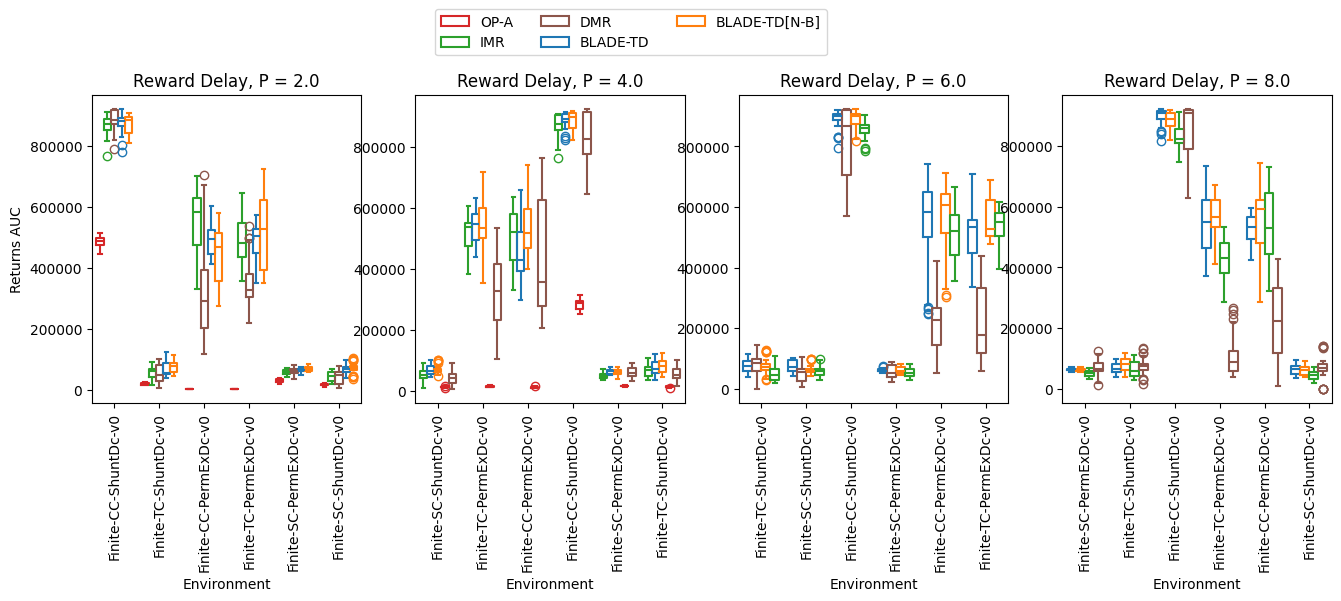

In [44]:
plot_auc(df_returns_auc)

## Time to Threshold Returns

In [45]:
def plot_delay_perf_curves(df_data, metric: str):
    df_raw = df_data[["env_name", "gamma", "delay_mu", "method", metric]]
    df_raw = copy.deepcopy(df_raw[df_raw["method"] != "FR"])
    palette = {key: pl for key, pl in METHODS_PALETTES.items() if key != "FR"}
    envs = sorted(df_raw["env_name"].unique())
    ncols = len(envs)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4))

    for env, ax in zip(envs, axes.flatten()):
        df_slice = df_raw[df_raw["env_name"] == env]
        sns.lineplot(
            data=df_slice,
            x="delay_mu",
            y=metric,
            hue="method",
            style="method",
            palette=palette,
            markers=True,
            dashes=False,
            ax=ax,
        )
        ax.set_title(env)

In [46]:
def calc_threshold_metrics(df_data, threshold: float = 0.9):
    fr_mask = df_data["method"] == "FR"
    df_fr = df_data[fr_mask]
    df_other = df_data[~fr_mask]

    rows = []
    # each row is a config: env x gamma x method x delay
    for row in df_other.to_dict("records"):
        # get baseline returns
        df_fr_slice = df_fr[
            (df_fr["env_name"] == row["env_name"]) & (df_fr["gamma"] == row["gamma"])
        ]
        fr_returns_matrix = np.stack(df_fr_slice.iloc[0]["runs_returns_matrix"])
        # returns at the last step
        fr_mean_returns_last_ep = np.mean(fr_returns_matrix[:, -1])
        method_returns_matrix = np.stack(row["runs_returns_matrix"])
        # Positive returns
        if fr_mean_returns_last_ep > 0:
            bound = threshold * fr_mean_returns_last_ep
        else:
            bound = (2 - threshold) * fr_mean_returns_last_ep
        # which episodic returns are above the treshold
        ep_above_threshold_mask = method_returns_matrix >= bound
        # which runs reach the threshold
        ep_that_reach_threshod_mask = np.sum(ep_above_threshold_mask, axis=1) > 0
        # first episode reaching threshold in each run
        first_ep_reaching_threshold = np.argmax(ep_above_threshold_mask, axis=1)
        # In runs reaching threshold, average episode
        mean_time_to_reach_threshold = np.mean(
            first_ep_reaching_threshold[ep_that_reach_threshod_mask]
        )
        # percentage of episodes tha reach threshold
        ep_that_reach_threshod = np.sum(ep_that_reach_threshod_mask) / len(
            ep_that_reach_threshod_mask
        )
        # time perce of episodes spent above threshold
        time_above_threshold = np.mean(
            np.sum(
                # use abs for negative returns
                ep_above_threshold_mask >= bound,
                axis=1,
            )
            / method_returns_matrix.shape[1]
        )
        # approx time spent within range of threshold
        # runs x episodes
        entry = copy.deepcopy(row)
        entry["mean_time_to_reach_threshold"] = mean_time_to_reach_threshold
        entry["perc_turns_reaching_threshold"] = ep_that_reach_threshod
        entry["time_above_threshold"] = np.mean(
            np.sum(
                # use abs for negative returns
                # TODO: check if pos or negative; differen top
                method_returns_matrix >= bound,
                axis=1,
            )
            / method_returns_matrix.shape[1]
        )
        rows.append(entry)
    return pd.DataFrame(rows)

In [47]:
def calc_env_method_return_perctile_ci(
    df_results: pd.DataFrame, confidence: float, decimals: int = 4
) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["method"].unique())

    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) & (df_results["method"] == method)
            ]
        )

        # across delays, gamma, and runs
        values = df_slice["time_above_threshold"].values
        ci_result, ci_fmt = calc_and_format_ci(
            values, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "method"])

In [48]:
df_threshold_metrics = calc_threshold_metrics(df_runs_returns)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
df_threshold_metrics.head()

,exp_id,runs_returns_matrix,runs_steps_matrix,env_name,gamma,method,meta,episodes,delay_type,delay_mu,mean_time_to_reach_threshold,perc_turns_reaching_threshold,time_above_threshold
0,1763050698-0116b72c-Finite-SC-ShuntDc-v0,"[[14272.50959203077, 3.761423074369891, 2373.5...","[[8809, 7, 334, 7, 759, 490, 330, 329, 452, 45...",Finite-SC-ShuntDc-v0,1.00,IMR,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0,0.333333,0.75,0.488
1,1763050698-01376e3a-Finite-TC-ShuntDc-v0,"[[28.41735305326786, 6.2993577469622775, 5.178...","[[21, 7, 7, 7, 378, 7, 1016, 7, 1478, 7, 836, ...",Finite-TC-ShuntDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0,27.150000,1.00,0.057
2,1763050698-025fc2cc-Finite-CC-ShuntDc-v0,"[[18626.034417630966, 15168.512536014448, 1216...","[[10000, 10000, 674, 10000, 10000, 10000, 1000...",Finite-CC-ShuntDc-v0,1.00,OP-A,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0,0.000000,0.85,0.018
3,1763050698-03997039-Finite-TC-PermExDc-v0,"[[37.37693281728467, 56.16353942788005, 17.057...","[[28, 23, 118, 361, 1817, 1043, 4987, 8524, 10...",Finite-TC-PermExDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0,5.450000,1.00,0.501
4,1763050698-03c0d284-Finite-SC-ShuntDc-v0,"[[14.119045999699605, 2457.3722724895765, 3.59...","[[13, 467, 7, 443, 7, 7, 647, 446, 747, 40, 43...",Finite-SC-ShuntDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176305069...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0,8.100000,1.00,0.208


In [50]:
calc_env_method_return_perctile_ci(df_threshold_metrics, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


method,BLADE-TD,BLADE-TD[N-B],DMR,IMR,OP-A
env_name,,,,,
Finite-CC-PermExDc-v0,0.4963 ± 0.0911,0.5451 ± 0.103,0.278 ± 0.0925,0.5288 ± 0.1589,0.0 ± nan
Finite-CC-ShuntDc-v0,0.941 ± 0.0203,0.9176 ± 0.0395,0.8659 ± 0.0733,0.8936 ± 0.0553,0.0082 ± 0.0145
Finite-SC-PermExDc-v0,0.8515 ± 0.0622,0.866 ± 0.0861,0.5349 ± 0.0773,0.452 ± 0.2129,0.046 ± 0.0492
Finite-SC-ShuntDc-v0,0.3768 ± 0.1949,0.3714 ± 0.2324,0.266 ± 0.1873,0.3219 ± 0.155,0.024 ± 0.0223
Finite-TC-PermExDc-v0,0.5459 ± 0.0644,0.6198 ± 0.0875,0.1816 ± 0.1101,0.4369 ± 0.1982,0.0 ± nan
Finite-TC-ShuntDc-v0,0.2569 ± 0.1856,0.3031 ± 0.2286,0.2877 ± 0.2446,0.2748 ± 0.2048,0.0235 ± 0.0246


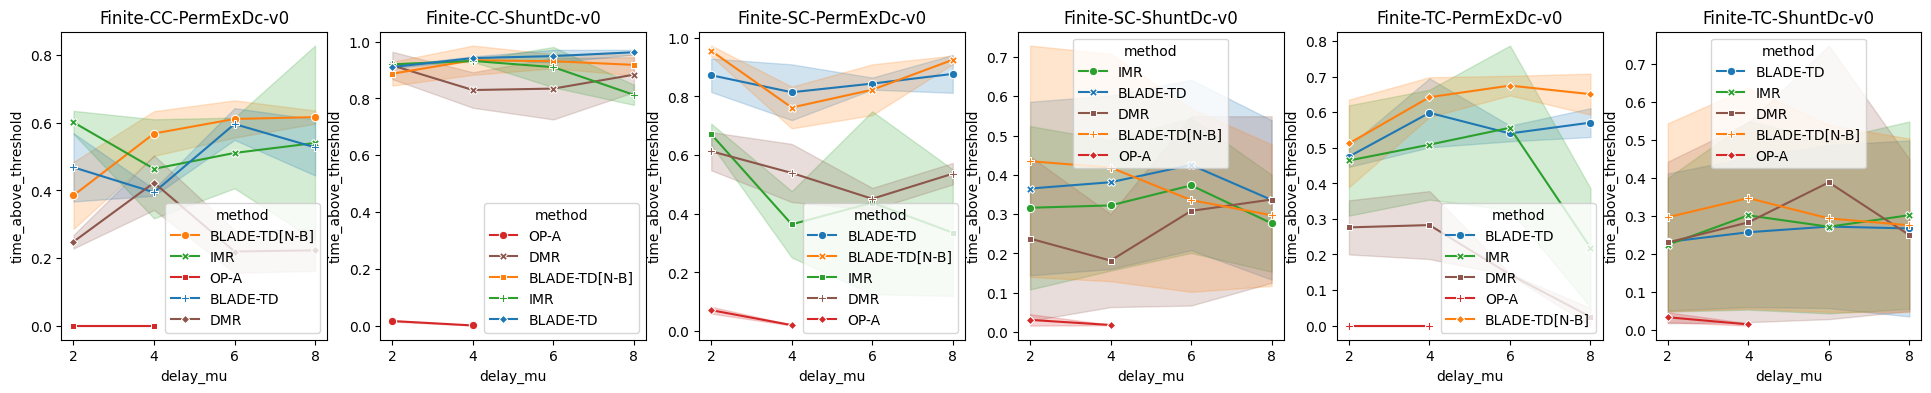

In [51]:
plot_delay_perf_curves(df_threshold_metrics, "time_above_threshold")

Most of these environments have high variance in their starts, or get worse before they get good.
Measuring time to reach a threshold result is unreliable.

## Method Efficiency per Delay

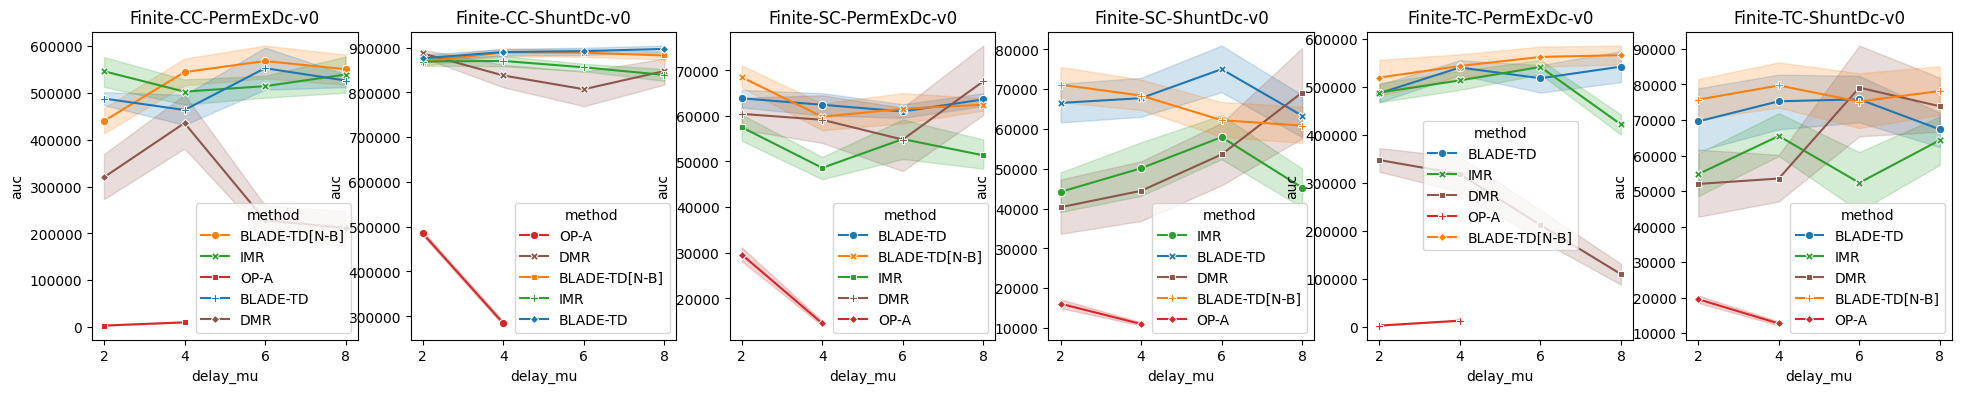

In [52]:
plot_delay_perf_curves(df_returns_auc.explode("auc").reset_index(), metric="auc")

## Returns Interquartile Mean @ K (IQM@K)

In [53]:
def calc_returns_iqm(df_data, confidence: float, decimals: int = 4):
    def calc_iqm_returns(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        runs_returns = runs_returns_matrix[:, -1]
        return stats.trimboth(runs_returns, proportiontocut=0.25)

    df_raw = copy.deepcopy(df_data)
    df_raw["iqm_returns"] = df_raw["runs_returns_matrix"].apply(calc_iqm_returns)

    envs = sorted(df_raw["env_name"].unique())
    methods = sorted(df_raw["method"].unique())
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = df_raw[(df_raw["env_name"] == env) & (df_raw["method"] == method)]
        # across delays, gamma, and runs
        values = np.stack(df_slice["iqm_returns"]).flatten()
        ci_result, ci_fmt = calc_and_format_ci(
            values, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)

    return pd.DataFrame(rows)

In [54]:
calc_returns_iqm(df_runs_returns, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)

method,BLADE-TD,BLADE-TD[N-B],DMR,FR,IMR,OP-A
env_name,,,,,,
Finite-CC-PermExDc-v0,12599.2495 ± 464.8504,12953.3129 ± 452.7308,7518.1803 ± 1025.0688,12138.1213 ± 1121.0789,12244.4394 ± 305.2905,216.2451 ± 50.4585
Finite-CC-ShuntDc-v0,18211.0028 ± 22.3437,18207.1592 ± 25.4932,18758.349 ± 29.7056,18254.6907 ± 49.3301,17554.7981 ± 139.9784,7896.9222 ± 572.8828
Finite-SC-PermExDc-v0,1234.8672 ± 7.5811,1231.8261 ± 9.0189,1114.2101 ± 52.8019,1247.6893 ± 15.3828,1104.268 ± 30.5836,209.0461 ± 21.2847
Finite-SC-ShuntDc-v0,2036.8074 ± 179.284,1958.8675 ± 162.0857,705.6372 ± 136.7514,2142.53 ± 406.0386,1654.13 ± 288.6791,91.2714 ± 7.0363
Finite-TC-PermExDc-v0,13075.0243 ± 386.1218,13298.834 ± 391.1684,8548.9229 ± 649.8268,12799.1529 ± 674.0067,12051.948 ± 194.3857,292.1703 ± 70.0705
Finite-TC-ShuntDc-v0,2789.6838 ± 365.5434,2865.7484 ± 351.2823,901.9157 ± 143.981,3541.2702 ± 1015.2969,2174.8855 ± 392.7512,107.1244 ± 8.5862


## Returns Running Coefficient of Variation (CV)

In [55]:
def calc_returns_cv(
    df_data, confidence: float, decimals: int = 4, window_size: int = 5
):
    def calc_rolling_cv(sequence):
        # Convert to pandas series for easy rolling ops
        series = pd.Series(sequence)
        # CV = Rolling Std / Rolling Mean
        res = series.rolling(window_size).std() / series.rolling(window_size).mean()
        return res.fillna(0).values

    def returns_cv(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        rows = []
        for i in range(runs_returns_matrix.shape[0]):
            row = calc_rolling_cv(runs_returns_matrix[i])
            rows.append(np.mean(row))
        return np.array(rows)

    df_raw = copy.deepcopy(df_data)
    df_raw["returns_rolling_cv"] = df_raw["runs_returns_matrix"].apply(returns_cv)

    envs = sorted(df_raw["env_name"].unique())
    methods = sorted(df_raw["method"].unique())
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = df_raw[(df_raw["env_name"] == env) & (df_raw["method"] == method)]
        # across delays, gamma, and runs
        values = np.stack(df_slice["returns_rolling_cv"]).flatten()
        ci_result, ci_fmt = calc_and_format_ci(
            values, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)
    return pd.DataFrame(rows)

In [56]:
calc_returns_cv(df_runs_returns, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)

method,BLADE-TD,BLADE-TD[N-B],DMR,FR,IMR,OP-A
env_name,,,,,,
Finite-CC-PermExDc-v0,0.3644 ± 0.0159,0.3384 ± 0.0193,0.8762 ± 0.0454,0.3645 ± 0.0303,0.3426 ± 0.0223,0.1984 ± 0.0304
Finite-CC-ShuntDc-v0,0.0383 ± 0.0061,0.0508 ± 0.0074,0.144 ± 0.0298,0.0266 ± 0.0136,0.0551 ± 0.0095,0.0733 ± 0.0095
Finite-SC-PermExDc-v0,0.1288 ± 0.0078,0.1224 ± 0.0132,0.614 ± 0.0416,0.1304 ± 0.0181,0.2678 ± 0.0176,0.2389 ± 0.0212
Finite-SC-ShuntDc-v0,0.2856 ± 0.0208,0.3054 ± 0.0248,0.8543 ± 0.0559,0.1855 ± 0.0307,0.7328 ± 0.0341,0.2099 ± 0.0197
Finite-TC-PermExDc-v0,0.2995 ± 0.0138,0.2452 ± 0.0143,0.7418 ± 0.0351,0.2507 ± 0.0279,0.2761 ± 0.0163,0.2048 ± 0.032
Finite-TC-ShuntDc-v0,0.4239 ± 0.0211,0.3711 ± 0.0239,0.8048 ± 0.0562,0.2478 ± 0.031,0.7077 ± 0.0425,0.2258 ± 0.0211


## For Print

### Relative Regret - Returns Ratio

In [57]:
def print_regret(
    df_data, suffix=None, method_filter_fn=lambda met: True, output_dir="figures/regret"
):
    df_raw = copy.deepcopy(
        df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]]
    )
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    if len(df_raw) == 0:
        return
    rps = sorted(df_raw["delay_mu"].unique())

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for rp in rps:
        df_plot = df_raw[df_raw["delay_mu"] == rp]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(
            df_plot,
            x="env_name",
            y="relative_regret",
            hue="method",
            palette=METHODS_PALETTES,
            ax=ax,
            fill=False,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Returns Ratio")
        ax.set_title(f"Reward Period, P = {rp}")
        name = f"regret_{suffix}_rp{rp}.pdf"
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches="tight")

In [58]:
print_regret(
    filter_envs(
        dfs_regret["sarsa"],
        envs=set(["GridWorld-v0", "IceWorld-v0", "MountainCar-v0", "RedGreen-v0"]),
    ),
    suffix="gym_sarsa",
)

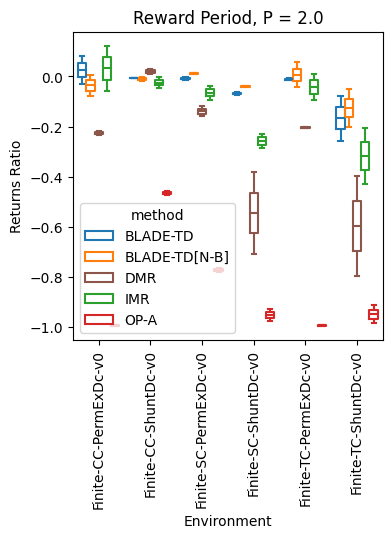

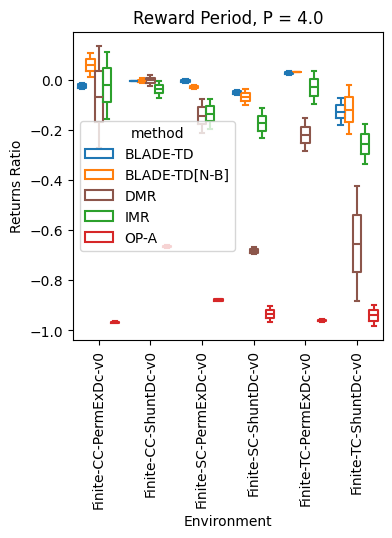

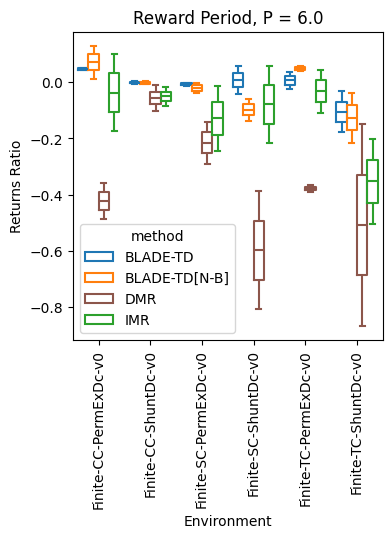

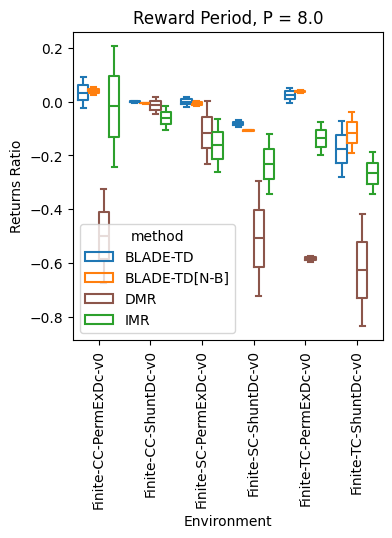

In [59]:
print_regret(
    filter_envs(
        dfs_regret["sarsa"],
        envs=set(
            [
                "Finite-CC-PermExDc-v0",
                "Finite-CC-ShuntDc-v0",
                "Finite-SC-PermExDc-v0",
                "Finite-SC-ShuntDc-v0",
                "Finite-TC-PermExDc-v0",
                "Finite-TC-ShuntDc-v0",
            ]
        ),
    ),
    suffix="gem_sarsa",
)

### Regret per Env

In [60]:
def plot_regret_dist(df_data, suffix, output_dir="figures/regret"):
    env_names = sorted(df_data["env_name"].unique())
    for env_name in env_names:
        df_slice = df_data[df_data["env_name"] == env_name]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.kdeplot(
            data=df_slice,
            x="relative_regret",
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.set_xlabel("Returns Ratio")
        ax.set_ylabel("Density")
        ax.set_title(f"Environment = {env_name}")
        name = f"regret_{suffix}_env_{env_name}.pdf"
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches="tight")

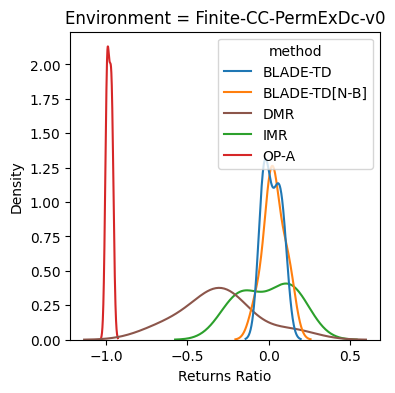

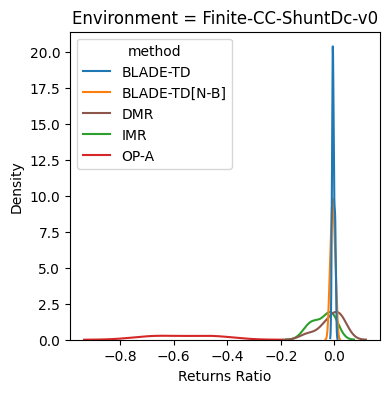

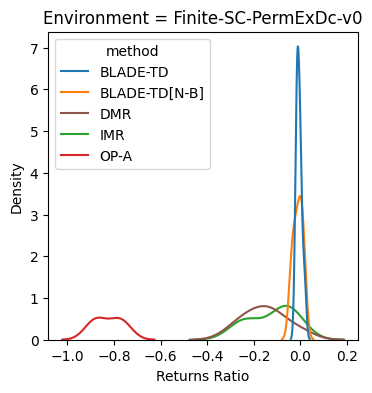

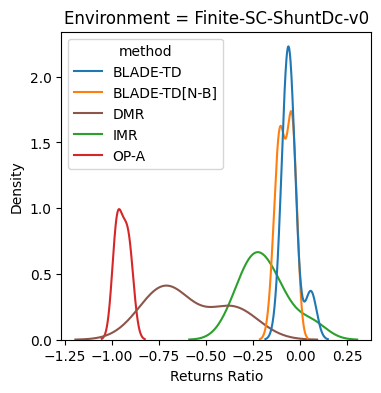

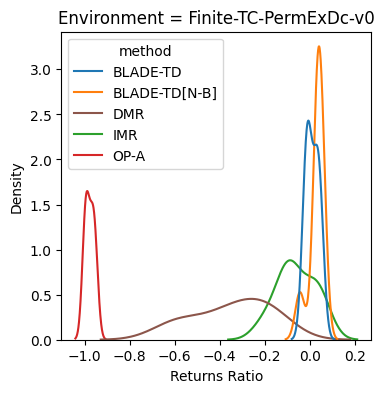

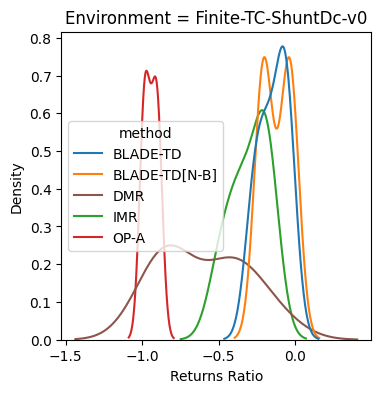

In [61]:
plot_regret_dist(dfs_regret["sarsa"], "sarsa")